<a href="https://colab.research.google.com/github/NIKHILCHAUHAN87667/ML_GenerativeAI_projects/blob/main/BitspaceModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Run this first in Colab
!pip install trimesh tqdm torch torchvision scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 9.6 MB/s eta 0:00:00


In [2]:
# Imports & config
import os
from pathlib import Path
import numpy as np
import trimesh
import torch
from tqdm import tqdm
import traceback

# CONFIG - edit paths below
INPUT_DIR = "/content/drive/MyDrive/dataset"   # <- put your models here
OUTPUT_DIR = "/content/drive/MyDrive/bitspace_voxels"  # <- where voxel outputs go
VOXEL_RES = 32   # start with 32^3
SAVE_NPY = True  # save individual .npy files
COMBINED_SAVE_PATH = os.path.join(OUTPUT_DIR, "bitspace_voxels.pt")

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("loaded")


loaded


In [3]:
# Helper functions
def normalize_mesh(mesh):
    """Center + uniformly scale mesh to unit extents."""
    if mesh is None or mesh.is_empty:
        return None
    try:
        mesh.remove_unreferenced_vertices()
    except Exception:
        pass
    ext = mesh.extents
    max_e = float(ext.max())
    if max_e <= 0 or np.isnan(max_e):
        return None
    # center
    try:
        mesh.apply_translation(-mesh.centroid)
    except Exception:
        pass
    # scale to fit into a cube of side 1.0
    try:
        mesh.apply_scale(1.0 / max_e)
    except Exception:
        return None
    return mesh

def mesh_to_voxel_matrix(mesh, res=32):
    """Voxelize to exactly (res,res,res) binary grid (uint8)."""
    try:
        # choose pitch assuming mesh extents ~1.0 after normalization
        pitch = mesh.extents.max() / max(1, (res - 1))
        v = mesh.voxelized(pitch=pitch)
        mat = v.matrix.astype(np.uint8)
        sx, sy, sz = mat.shape
        out = np.zeros((res,res,res), dtype=np.uint8)
        ox = (res - sx) // 2
        oy = (res - sy) // 2
        oz = (res - sz) // 2
        ex = min(sx, res - ox)
        ey = min(sy, res - oy)
        ez = min(sz, res - oz)
        out[ox:ox+ex, oy:oy+ey, oz:oz+ez] = mat[:ex, :ey, :ez]
        return out
    except Exception as e:
        # fallback: sample points on surface and rasterize them
        try:
            pts = mesh.sample(20000)
            pts = (pts - pts.min(axis=0))
            if pts.max() > 0:
                pts = pts / pts.max() * (res - 1)
            idx = np.floor(pts).astype(int)
            idx = np.clip(idx, 0, res-1)
            out = np.zeros((res,res,res), dtype=np.uint8)
            out[idx[:,0], idx[:,1], idx[:,2]] = 1
            return out
        except Exception:
            return None

def try_load_mesh(path):
    """Robust mesh loader using trimesh. Returns a single merged mesh or None."""
    try:
        m = trimesh.load(path, force='mesh')
        if isinstance(m, trimesh.Scene):
            # combine scene geometry into a single mesh
            try:
                meshes = [g for g in m.geometry.values()]
                if len(meshes) == 0:
                    return None
                m = trimesh.util.concatenate(meshes)
            except Exception:
                # fallback: attempt dump
                m = trimesh.util.concatenate(m.dump()) if hasattr(m, 'dump') else None
        return m
    except Exception:
        try:
            return trimesh.load_mesh(path)
        except Exception:
            return None


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VoxelUNetAutoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(VoxelUNetAutoencoder, self).__init__()

        # --- Encoder ---
        self.enc1 = nn.Sequential(
            nn.Conv3d(1, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )
        self.enc2 = nn.Sequential(
            nn.Conv3d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        self.enc3 = nn.Sequential(
            nn.Conv3d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )
        self.enc4 = nn.Sequential(
            nn.Conv3d(128, 256, 3, stride=2, padding=1),
            nn.BatchNorm3d(256),
            nn.ReLU(inplace=True)
        )

        # Bottleneck fully-connected compression
        self.fc1 = nn.Linear(256 * 4 * 4 * 4, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 256 * 4 * 4 * 4)

        # --- Decoder (with skip connections) ---
        self.up1 = nn.ConvTranspose3d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv3d(128 + 128, 128, 3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True)
        )
        self.up2 = nn.ConvTranspose3d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv3d(64 + 64, 64, 3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True)
        )
        self.up3 = nn.ConvTranspose3d(64, 32, 2, stride=2)
        self.dec3 = nn.Sequential(
            nn.Conv3d(32 + 32, 32, 3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True)
        )

        # Output
        self.final = nn.Conv3d(32, 1, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        # Encode
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)

        # Latent
        b = e4.view(e4.size(0), -1)
        latent = self.fc1(b)
        b = self.fc2(latent)
        b = b.view(e4.size())

        # Decode with skip connections
        d1 = self.up1(b)
        d1 = torch.cat([d1, e3], dim=1)
        d1 = self.dec1(d1)

        d2 = self.up2(d1)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d3 = self.up3(d2)
        d3 = torch.cat([d3, e1], dim=1)
        d3 = self.dec3(d3)

        out = self.final(d3)
        out = self.out_act(out)

        return out, latent


In [3]:
from torch.utils.data import Dataset, DataLoader
import random
from pathlib import Path
import torch

class VoxelDataset(Dataset):
    def __init__(self, directory):
        self.files = list(Path(directory).rglob("*.pt"))
        random.shuffle(self.files)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        data = torch.load(self.files[idx])
        voxel = data["voxel"].float()

        # ✅ Normalize tensor shape
        # Sometimes augmentation causes wrong ordering like (1,32,1,32,32)
        voxel = voxel.squeeze()  # remove any extra 1-dimensions
        shape = voxel.shape

        # Fix any misaligned dimensions
        if len(shape) != 3:
            voxel = voxel.view(32, 32, 32)

        voxel = voxel.unsqueeze(0)  # make it (1, D, D, D)
        return voxel
orig_dir = "/content/drive/MyDrive/bitspace_voxels"
aug_dir = "/content/drive/MyDrive/bitspace_voxels_augmented"

dataset = VoxelDataset(orig_dir) + VoxelDataset(aug_dir)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = VoxelUNetAutoencoder(latent_dim=512).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 95
lambda_bce = 0.1  # weight for BCE in the hybrid loss

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for vox in train_loader:
        vox = vox.to(device)
        recon, latent = model(vox)

        # --- Hybrid loss ---
        mse_loss = F.mse_loss(recon, vox)
        bce_loss = F.binary_cross_entropy(recon, vox)
        loss = mse_loss + lambda_bce * bce_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{EPOCHS}]  Loss: {avg_loss:.6f}")

# Save model
torch.save(model.state_dict(), "/content/drive/MyDrive/bitspace_voxel_autoencoder_hybrid.pth")
print("✅ Training complete with hybrid loss! Model saved.")


Using device: cuda
Epoch [1/95]  Loss: 0.149942
Epoch [2/95]  Loss: 0.065025
Epoch [3/95]  Loss: 0.035251
Epoch [4/95]  Loss: 0.021480
Epoch [5/95]  Loss: 0.014470
Epoch [6/95]  Loss: 0.010480
Epoch [7/95]  Loss: 0.008003
Epoch [8/95]  Loss: 0.006363
Epoch [9/95]  Loss: 0.005225
Epoch [10/95]  Loss: 0.004356
Epoch [11/95]  Loss: 0.003707
Epoch [12/95]  Loss: 0.003198
Epoch [13/95]  Loss: 0.002793
Epoch [14/95]  Loss: 0.002470
Epoch [15/95]  Loss: 0.002194
Epoch [16/95]  Loss: 0.001967
Epoch [17/95]  Loss: 0.001771
Epoch [18/95]  Loss: 0.001608
Epoch [19/95]  Loss: 0.001466
Epoch [20/95]  Loss: 0.001336
Epoch [21/95]  Loss: 0.001227
Epoch [22/95]  Loss: 0.001130
Epoch [23/95]  Loss: 0.001049
Epoch [24/95]  Loss: 0.000970
Epoch [25/95]  Loss: 0.000901
Epoch [26/95]  Loss: 0.000839
Epoch [27/95]  Loss: 0.000785
Epoch [28/95]  Loss: 0.000733
Epoch [29/95]  Loss: 0.000687
Epoch [30/95]  Loss: 0.000646
Epoch [31/95]  Loss: 0.000608
Epoch [32/95]  Loss: 0.000573
Epoch [33/95]  Loss: 0.000540


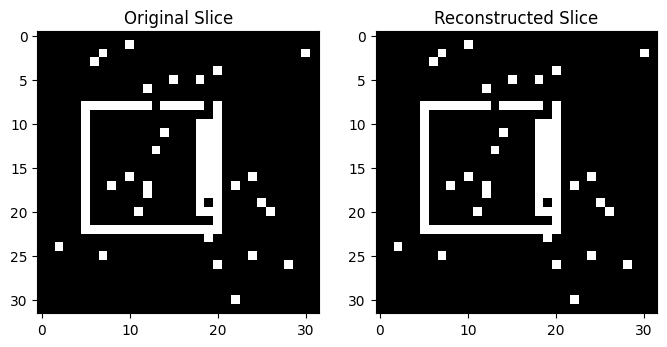

Latent vector size: 512 vs Original: 32768


In [6]:
import matplotlib.pyplot as plt

# Load model + one voxel sample
model.eval()
sample = next(iter(train_loader))[0].unsqueeze(0).to(device)
recon, latent = model(sample)

# Convert to numpy for visualization
orig_np = sample[0, 0].detach().cpu().numpy()
recon_np = recon[0, 0].detach().cpu().numpy()

# Visualize mid-slices
fig, axs = plt.subplots(1, 2, figsize=(8,4))
axs[0].imshow(orig_np[16], cmap='gray')
axs[0].set_title("Original Slice")
axs[1].imshow(recon_np[16], cmap='gray')
axs[1].set_title("Reconstructed Slice")
plt.show()

print(f"Latent vector size: {latent.numel()} vs Original: {orig_np.size}")


In [7]:
torch.save(model, "/content/drive/MyDrive/bitspace_autoencoder_full.pth")
print("✅ Full model (with architecture) saved!")


✅ Full model (with architecture) saved!
